# Short-Term Investment Strategies with Deep Q-Network (DQN)

## Table of Contents

> [1. Introduction](#Introduction--1)

> [2. Current SOTA](#SOTA--2)

> [3. The *environment* and *reward* signal](#env_and_reward--3)

> [4. Development and Implementation](#dev_and_impl--4)
>> - [4.1. Instatiation of the trading environment](#Instantiation--4-1)
>> - [4.2. Fundamental hyperparameters to tweak](#hyperparameters--4-2)
>> - [4.3. Observation Space: Relative Price Variations](#observation_space--4-3)

> [5. Deep Q-Network Acrhitecture](#DQN_architecture--5)
>> - [5.1. Experience Replay Buffer](#E_R_B--5-1)
>> - [5.2. Neural Network Architecture](#NN_Architecture--5-2)
>> - [5.3. Exploration Vs Exploitation](#Exploration_vs_Exploitation--5-3)
>> - [5.4. Policy Evaluation](#Policy_Evaluation--5-4)

> [6. Putting things together, Deep Q-Network algorithm](#Putting_things_together--6)
>> - [6.1. Compare *DQN* to *random_pi*](#compare--6-1)

> [7. What our Agent is Capable of](#capabilities--7)

> [8. Conclusions, Limitations and Future Improvements](#Conclusions--8)

> [9. Appendix](#Appendix--9)
>> - [9.A. On the formulation of the Markov Decision Process in financial trading](#Appendix--9-A)


## 1. Introduction  <a name = "Introduction--1"></a>

The goal of this Jupyter Notebook is to explore the application of **Deep Reinforcement Learning**, and in particular the **Deep Q-Network (DQN)** algorithm, in the domain of financial investments, with a focus on **short-term investment strategies** in a very ***vanilla-base*** **implementation**.

The investment landscape can be broadly divided into two main categories.  
1. **Long-term investments**, typically rely on macroeconomic factors, political events, corporate decisions, and geopolitical dynamics, and are often analyzed through [fundamental analysis](https://en.wikipedia.org/wiki/Fundamental_analysis).  
2. **short-term investments**, which include trading activities, operate over much shorter time horizons and are commonly studied using mathematical and statistical models.

Traditional approaches in quantitative finance for short-term price modeling include tools such as **ARIMA models**, **Geometric Brownian Motion (GBM)**, and model-based frameworks like the **Black–Scholes model**, (if you are interested, see my [arXiv paper here](https://arxiv.org/pdf/2510.27277)). While powerful, these methods rely on strong assumptions about market dynamics.

In this notebook, we adopt a different perspective by leveraging **Artificial Intelligence**, in particular **Reinforcement Learning (RL)**.\
Instead of explicitly modeling price dynamics, we allow an agent to **learn a trading policy directly from interactions with the market environment**, guided by a reward signal.

A crucial step in this process is the design of a suitable **trading environment**. The environment must comply with the standard **Gymnasium** interface and provide:
- A well-defined **action space** (e.g.: buy, sell, hold);
- An **observation space** representing the market state;
- Proper **termination and truncation conditions**;
- A **reward function** that encodes the trading objective.

Once the environment is defined, it is coupled with a **DQN agent**, which is trained through repeated interactions with the market.\
Finally, the trained agent's policy is evaluated by analyzing the accumulated rewards compared to a random policy, in order to assess the effectiveness and robustness of the learned trading strategy.


<div style="text-align: center;">
    <img src="trading_bot.JPG" alt="trading bot image" width="66%"/>
</div>


## 2. Current SOTA <a name="SOTA--2"></a>

It is important to point out that [Gymnasium](https://gymnasium.farama.org/), which is a standardized API for RL ready-to-use environments, currently does not have any predefined trading environment, all we have are some projects carried out 'unofficially', that often lack of correctness and rigorous methoods or documentation.

* [gym-anytrading](https://github.com/AminHP/gym-anytrading), repository GitHub for a possible trading environment.
* [tensortrade](https://github.com/tensortrade-org/tensortrade), Python library for reinforcement learning applied in trading.
* [q-trader](https://github.com/edwardhdlu/q-trader?tab=readme-ov-file), application of reinforcement learning in the stock market.
* [Reinforcement Learning Framework for Quantitative Trading](https://arxiv.org/html/2411.07585v1), scientific paper about the application of deep RL in trading.
* [Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy](https://arxiv.org/abs/2511.12120), scientific paper about the application of deep RL combined with an ensemble strategy in trading.

The first three, seem to be the most relevant sources we can find on the web, but as already noted, they lack of proper documentation and rigorous method.

The second two files are accademic projects carried out by researchers about the application of refined RL techniques in trading.

In any case, the application of RL techniques in investments is already quite widespread as mentioned by this article [link](https://medium.com/ibm-data-ai/reinforcement-learning-the-business-use-case-part-2-c175740999), where prestigious firms suchs IBM or J.P. Morgan, already apply some of these techniques.

## 3. The *environment* and  *reward* signal <a name="env_and_reward--3"></a>

Given the current SOTA available and having understood the main dynamics of a market stock, the first thing to do, is the design of our own environment.\
The Python script `tradingenv` contains our environment class, `TradingEnv()`. It could be used as a starting point for many other RL projects, since it contains a proper methodology with many comments that enhance the understanding of the development.

TradingEnv has all the methods that make it compliant to the Gym environments. But the most relevant thing to understand is how the **reward** signal is defined, as shown here:

$ reward = (cash_{t+1} + shares_{t+1} \cdot p_{t+1}) - (cash_{t} + shares_{t} \cdot p_{t}) $

where:
* $reward$, indicates the reward obtained after taking the action at time-step $t$
* $cash_{t}$, indicates the amount of cash held at time step $t$
* $share_{t}$, indicates the amount of shares held at time step $t$
* $p_{t}$, indicates the price of a single share at time step $t$

## 4. Development and Implementation <a name="dev_and_impl--4"></a>

import of all the necessary libraries, environment, numerical computations, NN and rendering...\
Make sure to have the script `tradingenv`!

In [1]:
#import of our defined environment
#YOU MUST ALSO HAVE THE SCRIPT "tradingenv.py"
from tradingenv import TradingEnv

import torch #for Neural Networks
import numpy as np #for numerical operations
import random #for random number generation
import matplotlib.pyplot as plt #for plotting the results

Practical example of how to use the library

In [ ]:
""" example of how to use the described environment
env = TradingEnv(ticker="AAPL", granularity="1d", sliding_window=7, start_date="2020-01-01", end_date="2021-01-01", initial_cash=10000, initial_share=5)
obs, info = env.reset()
action = env.action_space.sample()  # es. 0=buy,1=hold,2=sell
obs, reward, done, truncated, info = env.step(action)
"""

### 4.1 Instantiation of the trading environment <a name="Instantiation--4-1"></a>

Note, you can select the granularity as the interval parameter of the `yfinance` [library](https://ranaroussi.github.io/yfinance/), representing the time scale over which you want to operate.\
Supported time scale: 

#### Short-time trading (intraday)

* `1m` – 1 minute
* `2m` – 2 minutes
* `5m` – 5 minutes
* `15m` – 15 minutes
* `30m` – 30 minutes
* `60m` – 60 minutes
* `90m` – 90 minutes
* `1h` – 1 hour

#### Long-time trading (daily and others)
* `1d` – 1 day
* `5d` – 5 days
* `1wk` – 1 week
* `1mo` – 1 month
* `3mo` – 3 months

In [2]:
#instatiate the environment
#HYP!
env = TradingEnv(ticker="QQQ", granularity="1d", sliding_window=10, start_date="2014-01-01", end_date="2016-01-01", initial_cash=10000, initial_share=10)

state_size = env.observation_space.shape
action_size = env.action_space.n

print('State Space: ', state_size)
print('Action Space: ', action_size)

State Space:  (10,)
Action Space:  3


### 4.2. Fundamental hypeparamenters to tweak <a ame="hyperparameters--4-2"></a>

* The `ticker` depends on the `yfinance` nomenclature.
* The `granularity` hyperparameter as already mentioned is crucial, and depends on the type of trading the user wants to perform.
* The `slidinig_window` should be approximately 10 days with a maximum of 20, but for the sake of computational efficiency we have decided to set it to 7 days (keep in mind that it also depends on the type of trading the user want to perform).
* The `start_date` and `end_date` will generate the amount of data used for training in the period of interest, we must tweak them according to our purpose, but generally speaking they should cover a period of circa 5 years, in order to enclose possible financial market cycles.
* The `initial_cash` and `initial_share` combined, represent the agent initial wallet value, and are of crucial importance for the learning of behaviour, **we must give to the agent a proper amount of stock and cash available at the beginning, otherwise it will learn degenerative policy.**\
**Note that the two amounts should depend on the market considered.**

**NOTE** that a complete year of data (e.g.: `start_date='2020-01-01'` and `end_date='2021-01-01'`), with `granularity="1d"`, contains approximately `253` prices, behave accordingly when you tweak fundamental hyperparameters, such as the batch size, episodes...

**NOTE** since DQN is a value based approach, and since this Notebook could be implemented in many different cases, there are a lot of hyperparameters.\
To ease the user's coding, we allow the possibility to decline this notebook by tweaking them accordingly.\
Before every hyperparameter, in the code has been put a: `#HYP!`, so with a simple `Ctrl`+`f`, all hyperparameters can be found.

### 4.3. Observation Space: Relative Price Variations <a name="observation_space--4-3"></a>

It is important to emphasize that the observation space is defined in terms of **percentage price variations** rather than **absolute price levels**.  
This choice is fundamental from both a financial and a reinforcement learning perspective.

Absolute prices are not directly comparable across assets or time periods: a price change of +1 has a very different meaning for an asset trading at 10 compared to one trading at 1,000. By using relative variations, the agent receives **scale-invariant information**, allowing it to learn patterns that are independent of nominal price levels.

Moreover, financial markets are highly **non-stationary** in absolute terms, as prices tend to drift over time. Percentage variations, instead, exhibit more stable statistical properties, making them more suitable as inputs for learning algorithms and improving training stability.

Finally, relative variations naturally align with the **economic objective of trading**, since profits and losses are inherently relative quantities. For these reasons, the observation space is constructed using relative price changes, enabling better generalization and a more meaningful learning process for the DQN agent.

If you are interested, here is a similar project of mine where I needed stationarity in time series [Fast Fourier Transform in Finance](https://github.com/fraro01/Fourier-Transform-in-Finance)

### What our agent is training on

Show what we are analyzing, the time series of interest, note that we use as prices the closing prices given by `yfinance`. This behaviour can be changed by simply tweaking the related hyperparameter from the `tradingenv.py`

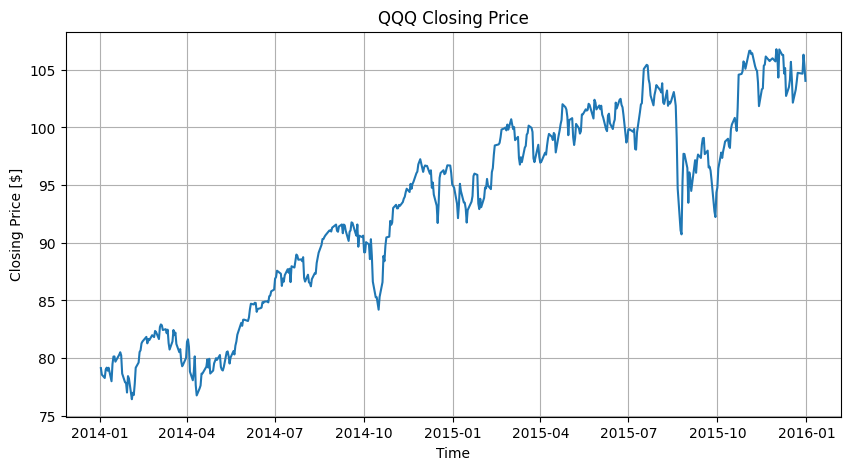

In [3]:
#method of the TradingEnv class to show the data used for training
env.show_data()

We fix the seed of the random number generator in order to reproduce the results

In [4]:
# set the seeds for reproducibility of results
seed = 42 #HYP!

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

42

If available on the current calculator, we take advantage of the **GPU** computational power

**NOTE** make sure to have installed a `Pytorch` version capable of handling GPU computation! Otherwise the following code will not bring any computational improvement!

In [5]:
# set the backend device to MPS or CUDA, if available
if torch.cuda.is_available(): #prioritize CUDA since it is more powerful
    device = torch.device("cuda") #windows
elif torch.backends.mps.is_available():
    device = torch.device("mps") #mac
else:
    device = torch.device("cpu")
# print the used device
print(f"Using device: {device}")

Using device: cuda


## 5. Deep Q-Network Architecture <a name="DQN_architecture--5"></a>

### 5.1. Experience Replay Buffer <A name="E_R_B--5-1"></a>

Experience Replay Buffer, for the creation of semi-independent experiences to train the agent, in order to adress the first issue given by: *i.i.d*

Definition of the single array of experience

In [6]:
# define the structured dtype for an experience tuple, which will be stored in the replay memory
experience_type = np.dtype([
    ('state',      np.float32, state_size),   # current state, it must take the array of the observation space
    ('action',     np.int8),                  # action taken, it is JUST THE action we took
    ('reward',     np.float32),               # reward received
    ('next_state', np.float32, state_size),   # next state
    ('failure',    np.int8)                   # terminal flag (1 if done)
])

Definition of the container of the arrays (replay buffer)

In [7]:
# Set the replay memory size hyperparameter
#HYP!
memory_size = 1000 #ADJUST IT ACCORDINGLY, (it was set to 100000 at the beginning)

# Create the replay memory
replay_memory = {
    'size': memory_size,
    'buffer': np.empty(shape=(memory_size,), dtype=experience_type),
    'index': 0,
    'entries': 0
}

Function to store a new experience in the replay buffer

In [8]:
def store_experience(experience):
    # store the experience in the buffer
    replay_memory['buffer'][replay_memory['index']] = experience #we overwrite the experience at the current index, if the buffer is not full it will be empty, otherwise it will overwrite the oldest experience

    # update the number of experiences in the buffer
    replay_memory['entries'] = min(replay_memory['entries'] + 1, replay_memory['size']) # it cannot exceed the maximum size of the buffer

    # update index, if the memory is full, start from the begging
    replay_memory['index'] += 1
    replay_memory['index'] = replay_memory['index'] % replay_memory['size'] #as long as 'index' is lower than 'size' it outputs 'index', then once they are equal it outputs 0

Function to sample a mini-batch of experiences from the replay buffer defined above.\
We will train the agent over these mini-batches.

**IMPORTANT** since financial time series, cannot be modelled as a proper Markov Decision Process <small>[(see the Appendix at the end)](#Appendix--9-A)</small>, we cannot implement a uniform random sampling over the experience replay buffer, as for a typical DQN implementation, otherwise we mix different regimes losing the context.\
Instead, in this case we take the *sequential* last *`batch_size`-th* experiences collected, in order to preserve the context and temporal coherence, and we do that maintaining the circularity of our experience replay buffer, hence the `batch_size` hyperparameter, represents how much in the past history we go, in order to compute the backpropagation for the `online_network`.

If you want to implement the real DQN algorithm you should only run the cell below and skip the following one.\
Instead, if you want to keep a bit of correlation among consecutive samples from the training time series, you should run the second definition of the `sample_experiences()` function, as it mantains a correlation-trajectory of the samples when it picks them up from the Experience Replay Buffer. Note that this implementation is against the *indipendence* principle of the *i.i.d.* statement, and you should calibrate it properly from the `batch_size` hyperparameter. though, this implementation maintains the circularity of the experience replay buffer.

In [9]:
# Set the batch size for sampling experiences
batch_size = 30

# function to sample a batch of experiences from the replay memory
def sample_experiences():

    # select uniformly at random a batch of experiences from the memory
    idxs = np.random.choice(range(replay_memory['entries']), batch_size, replace=False)

    # return the batch of experiences
    experiences = replay_memory['buffer'][idxs]

    return experiences

In [ ]:
# Set the batch size for sampling experiences
#HYP!
batch_size = 30 #hyperparameter to be tweaked, it represents how much in the past history we go for computing the backpropagation (it was 32 at the beginning)

# function to sample a batch of experiences from the replay memory
def sample_experiences():

    """ IMPOMRTANT, SEE THE NOTES WRITTEN ABOVE
    # select uniformly at random a batch of experiences from the memory
    idxs = np.random.choice(range(replay_memory['entries']), batch_size, replace=False) #without replacement, we want unique experiences in the batch, if 'entries' is lower than 'batch_size' it will raise an error, but in that case we should not sample a batch of experiences, we should wait until we have enough experiences in the buffer
    # return the batch of experiences
    experiences = replay_memory['buffer'][idxs]
    return experiences
    """

    #in case we are not circular
    #experiences = replay_memory['buffer'][:replay_memory['entries']][-batch_size:]

    # --- take the last `batch_size` sequential experiences (chronological order) ---
    entries = replay_memory['entries']
    size = replay_memory['size']
    if entries < batch_size:
        raise ValueError(f"Not enough entries in replay memory to sample {batch_size} items (have {entries}).")

    # 'index' points to the next insertion position, so last inserted element is at index-1 (mod size)
    end = (replay_memory['index'] - 1) % size
    start = (replay_memory['index'] - batch_size) % size

    if start <= end:
        idxs = np.arange(start, end + 1)
    #CIRCULARITY: if start > end, it means we have wrapped around the buffer
    else:
        # wrap-around: take slice from start..size-1 then 0..end
        idxs = np.concatenate((np.arange(start, size), np.arange(0, end + 1)))

    # ensure idxs length == batch_size
    assert len(idxs) == batch_size

    # preserve chronological order: older -> newer
    experiences = replay_memory['buffer'][idxs]

    return experiences

### 5.2. Neural Network Architecture <a name="NN_Architecture--5-2"></a>

Since we are dealing with a continuous environment (continuous price variations), we are not in the field of tabular data, hence we need a function approximator for the value functions, this is the reason why we end up with the Neural Network Architecture for the $Q$ function.\
See the concept of the [Density of $\mathbb{Q}$ in $\mathbb{R}$](https://math.stackexchange.com/questions/103839/proof-that-mathbbq-is-dense-in-mathbbr)

It will output the $Q(s,a)$ for all possible *actions* in the given state $s$, after the observation taken as input.\
Here many hyperparameters could be tweaked, such as the hidden layers.

In [10]:
#hyperparameters for the neural network architecture to be tweaked
#HYP!
first_hidden_layer= 64
second_hidden_layer= 32
third_hidden_layer= 8

def create_network():

      # Define a deep neural network using Sequential:
      # Each layer feeds directly into the next one.
      dnn = torch.nn.Sequential( 
            # First fully connected layer maps state inputs to 512 hidden units
            torch.nn.Linear(state_size[0], first_hidden_layer),
            
            # ReLU activation introduces nonlinearity
            torch.nn.ReLU(),
            
            # Second fully connected layer (hidden layer with 128 units)
            torch.nn.Linear(first_hidden_layer, second_hidden_layer),
            
            # Another ReLU activation
            torch.nn.ReLU(),
            
            # Third fully connected layer (hidden layer with 64 units)
            torch.nn.Linear(second_hidden_layer, third_hidden_layer),
            
            # Another ReLU activation
            torch.nn.ReLU(),
                       
            # Output layer: one unit per possible action
            # Produces Q-values
            torch.nn.Linear(third_hidden_layer, action_size)
      )
    
      # Return the constructed model
      return dnn.to(device) #the model goes to the chosen device (GPU or CPU)

Creation of two separated networks (in terms of weights, since they are created from the same exact acrhitecture), in order to adress the second issue in *i.i.d.*, of *identically distributed* targets.

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta^{-}) - Q(s,a;\theta))^2 \right]$

In [11]:
#we need two separates network for the proper backpropagation defined in DQN
online_q = create_network() # online q-network for the prediction
target_q = create_network() # target network for the Ground-Truth Q-value estimation

Optimizer only for the online network, since is the only one to be trained

In [12]:
#the variable "optimizer" will be used below by the "optimizie()" function, in order to only backpropagate the gradients on the online_q parameters, while the target_q parameters will be updated only when we call the "update_target" function, which copies the online_q parameters to the target_q parameters
#HYP!
learning_rate = 0.004 #(at the beginning it was 0.007)
optimizer = torch.optim.RMSprop(online_q.parameters(), lr=learning_rate)

The target network is not trained, but sometimes we need to **update its weights to match the online network weights**

In [13]:
def update_target():
    # copy the parameters from the online model to the target model
    for target, online in zip(target_q.parameters(), online_q.parameters()):
        target.data.copy_(online.data)

Optimizer, for computing the loss and the backpropagation

In [14]:
# define the discount factor
#HYP!
gamma = 0.95 #(at the beginning it was 0.99)

def optimize():

    # sample a batch of experiences from the replay buffer, as mentioned in the last cell of section 5.1.
    batch = sample_experiences()
    
    # prepare the experience as tensors, take 'em all from the whole batch
    states      = torch.from_numpy(batch['state'].copy()).float().to(device) #we transfer all of them to the chosen device (GPU or CPU)
    actions     = torch.from_numpy(batch['action'].copy()).long().to(device)
    rewards     = torch.from_numpy(batch['reward'].copy()).float().to(device) 
    next_states = torch.from_numpy(batch['next_state'].copy()).float().to(device)
    failures    = torch.from_numpy(batch['failure'].copy()).float().to(device)

    # get the values of the Q-function at next state from the "target" network 
    # remember to detach, we need to treat these values as constants 
    q_target_next = target_q(next_states).detach() #treat the tensor as a constant, do not calculate the gradient with respect to it
    
    # get the max value 
    max_q_target_next = q_target_next.max(1)[0]

    # one important step, often overlooked, is to ensure 
    # that failure states are grounded to zero
    max_q_target_next *= (1 - failures.float())

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a)
    # here we query the current "online" network
    q_online_current = torch.gather(online_q(states), 1, actions.unsqueeze(1)).squeeze(1)

    # create the errors
    td_error = target - q_online_current

    # calculate the loss
    loss = td_error.pow(2).mean()

    # backward pass: compute the gradients
    optimizer.zero_grad() #set to zero the gradients of the parameters, otherwise they would be accumulated across optimization steps
    loss.backward() #backpropagation based on the "loss" variable

    # update model parameters
    #NOTICE thta optimizer is a defined variable (see cells above) on the online_q parameters, so it will update those parameters based on the computed gradients, while the target_q parameters will remain unchanged until we call the "update_target" function
    optimizer.step() #update the parameters of the online model based on the computed gradients

### 5.3. Exploration Vs Exploitation <a name="Exploration_vs_Exploitation--5-3"></a>

Hyperparameters to be set for the exploration straetegies. *($\epsilon$ decay)*

In [15]:
#HYP!
# define decay parameters (max, min, steps)
#uncomment the following two lines, if you want to use the normalization or scaling of epsilons, otherwise you can tweak the hyperparameters in the logspace generation of epsilons to get the desired range without needing to scale them
#epsilon_max = 1.0
#epsilon_min = 0.01
epsilon_decay_steps = 7500 #(it was set to 10000 at the beginning), adjust it according to your environment.

# generate epsilons
epsilons = np.logspace(start=0, stop=-2, num=epsilon_decay_steps, base=10)

#simplest method to change values of epsilons
epsilons = epsilons**0.5 #powers < 1, emphasize greater values => more exploration! balance this hyperparameter!

#THE FOLLOWING ARE TWO ALTERNATIVE WAYS TO SCALE THE EPSILONS TO THE DESIRED RANGE, YOU CAN CHOOSE ONE OF THEM, OR TWEAK THE HYPERPARAMETER IN THE LOGSPACE GENERATION OF EPSILONS TO GET THE DESIRED RANGE WITHOUT NEEDING TO SCALE THEM

# normalize epsilons 
# epsilons = (epsilons - epsilon_min) / (epsilon_max - epsilon_min)
    
# scale  epsilons to the desired range
# epsilons = (epsilon_max - epsilon_min) * epsilons + epsilon_min

Chosen exploration strategy.\
Based on the picked $\epsilon$, we alternate a random action selection and the greedy selection (greedy based on the value of the $Q(s,a,\theta)$ returned by our neural network).

`random_pi()` is the baseline random policy, to be used as reference, in order to understand whether we are actually learning smoething

In [16]:
def random_pi(state):
    # selects an action uniformly at random
    # from the environment's action space.
    return env.action_space.sample()

At the end of training the online network will be used to implement the policy.\
`dqn_policy()` it simply acts greedy given the input state.

In [17]:
def dqn_pi(state):
    # convert the state into a tensor
    state = torch.as_tensor(state, dtype=torch.float32).to(device)

    # compute Q-values from the network
    #since Python/Numpy is not able to read tensors in the GPU, in general if we need values outside training
    #we need to transfer them from the GPU to the CPU, but keep in mind that the transfer is computationally intense!
    q_values = online_q(state).detach().cpu().numpy().squeeze()

    # select greedy action
    action = int(np.argmax(q_values)) 

    # return the action
    return action

`epsilon_greedy()` combines `random_pi()` and `dqn_pi()` in order to be indeed $\epsilon$-greedy decaying

In [18]:
def epsilon_greedy(state, step):
    epsilon_min = 0.1 #the last value to keep taking, once we have finished al the decayed array
    # get the epsilon value    
    epsilon = epsilons[step] if step < epsilon_decay_steps else epsilon_min

    # Exploration
    if random.random() < epsilon:
        action = random_pi(state)

    # Exploitation
    else:
        action = dqn_pi(state)
    
    return action

### 5.4. Policy Evaluation <a name="Policy_Evaluation--5-4"></a>

Function to evaluate a policy, it returns the average reward obtained over a number of episodes

In [19]:
def evaluate(pi, episodes=1):

    # collect total rewards per episode
    rewards = []
    actions = [] #used only if the episodes==1

    # loop over episodes
    for episode in range(episodes):

        # reset the environment
        state, _ = env.reset()
        done = False
        total_reward = 0.0

        # run an episode
        while not done:
            action = pi(state)
            state, reward, terminal, truncated, _ = env.step(action)
            total_reward += reward
            done = terminal or truncated
            
            #if we only run one episode, we could be interested in the types of actions taken
            if episodes == 1:
                actions.append(action)

        # store the total reward    
        rewards.append(total_reward)
            
    # return the average reward over the episodes, and if we only run one episode, also return the types of actions taken in that episode      
    return np.mean(rewards), actions 

## 6. Putting things together, Deep Q-Network Algorithm <a name="Putting_things_together--6"></a>
Putting all the things together

In [20]:
def dqn(memory_start_size, target_update_steps, max_episodes):
    
    # create a score tracker for statistic purposes
    scores = []
    
    # counter for the number of steps 
    step = 0

    # update the target model with the online one, before even starting, so to allign the two NNs
    update_target()
                   
    # train until the maximum number of episodes
    for episode in range(max_episodes):
        
        # reset the environment before starting the episode
        state, _ = env.reset()
        done = False

        # interact with the environment until the episode is done
        while not done:
                    
            # select the action using the exploration policy
            action = epsilon_greedy(state, step)

            # perform the selected action
            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated
            failure = terminal and not truncated

            # store the experience into the replay buffer
            experience = (state, action, reward, next_state, failure)
            store_experience(experience)
    
            # optimize the online model ONLY AFTER the replay buffer is large enough
            if replay_memory['entries'] > memory_start_size:
                optimize()
                 
                # sometimes, synchronize the target model with the online model
                if step % target_update_steps == 0:
                    update_target()
                
            # update current state to next state
            state = next_state

            # update the step counter
            step += 1

        # After each episode, evaluate the policy
        score = evaluate(dqn_pi, episodes=10)[0]

        # store the score in the tracker
        scores.append(score)

        # print some informative logging for each episode!
        message = 'Episode {:03}, score {:05.1f}'
        message = message.format(episode+1, score)
        print(message, end='\r', flush=True)
        
    return scores

Apply the DQN to our `TradingEnv`

In [21]:
#HYP!
# set the hyperparameters
memory_start_size = 88 #ADJUST IT ACCORDINGLY IT IS CRUCIAL, (it was set to 1000 at the beginning), it is the number of experiences we need to have in the replay buffer before starting the optimization of the online model, it should be at least equal to the batch size, but it can be higher, if we want to have more diverse experiences in the buffer before starting to optimize the model
target_update_steps = 15 #steps between two updates of the target network, (it was set to 10 at the beginning), it is a crucial hyperparameter to be tweaked, if it is too low, the target network will be updated too often and it will not provide a stable target for the online network, if it is too high, the target network will be updated too rarely and it will not track the online network enough, so we need to find a good balance
max_episodes = 300 #ADJUST IT ACCORDINGLY (at least 200 at least!, but we aim 1000)

#run the algorithm
dqn(memory_start_size, target_update_steps, max_episodes)

C:\Users\fraro\AppData\Local\Temp\ipykernel_8592\3259473271.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  replay_memory['buffer'][replay_memory['index']] = experience #we overwrite the experience at the current index, if the buffer is not full it will be empty, otherwise it will overwrite the oldest experience


[np.float64(235.8792953491211),
 np.float64(4.638050842285156),
 np.float64(228.2448959350586),
 np.float64(220.9525909423828),
 np.float64(-1.7596450805664063),
 np.float64(0.5814933776855469),
 np.float64(495.81089782714844),
 np.float64(207.70269775390625),
 np.float64(221.12952423095703),
 np.float64(218.43706512451172),
 np.float64(175.61668395996094),
 np.float64(2170.041879272461),
 np.float64(1.1460670471191405),
 np.float64(205.74566650390625),
 np.float64(2464.0007553100586),
 np.float64(193.1142120361328),
 np.float64(165.19584732055665),
 np.float64(2530.7943840026855),
 np.float64(1838.47822265625),
 np.float64(2491.7454010009765),
 np.float64(1729.1552368164062),
 np.float64(2225.8718559265135),
 np.float64(2129.7366577148437),
 np.float64(25.846097564697267),
 np.float64(94.67151107788087),
 np.float64(2270.1400604248047),
 np.float64(2061.9490798950196),
 np.float64(2321.428522491455),
 np.float64(2346.374013519287),
 np.float64(2108.357054901123),
 np.float64(2201.5529

### 6.1. Compare *DQN* to *random_pi* <a name="compare--6-1"></a>

Experiment to understand how dqn is learning over the episodes

In [22]:
def experiment(max_episodes):

    global online_q, target_q, optimizer, replay_memory, epsilons

    #HYP!
    # List of random seeds to test algorithm stability
    seeds = (12, 34, 56, 78, 90)

    # Container to collect all experiment results
    results = []

    # Run an independent training experiment per seed
    for seed in seeds:

        print("Experiment seed: ", seed)

        # Set all relevant random seeds for reproducibility
        #NOTE THAT FOR EACH EPISODE WE INITIALIZE EVERYTHING FROM SCRATCH, SO WE NEED TO SET THE SEEDS FOR EACH EPISODE
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # reset the environment
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # create online and target models
        online_q = create_network()
        target_q = create_network()
        optimizer = torch.optim.RMSprop(online_q.parameters(), lr=learning_rate)

        # create the replay memory
        replay_memory = {
            'size': memory_size,
            'buffer': np.empty(shape=(memory_size,), dtype=experience_type),
            'index': 0,
            'entries': 0
        }

        # create the epsilon values from scratch
        #HYP!
        epsilons = np.logspace(start=0, stop=-2, num=epsilon_decay_steps, base=10)
        #epsilons = (epsilons - epsilon_min) / (epsilon_max - epsilon_min)
        #epsilons = (epsilon_max - epsilon_min) * epsilons + epsilon_min
        epsilons = epsilons**0.5 #hyperparamet to tune!

        # train the network    
        scores = dqn(memory_start_size, target_update_steps, max_episodes)
        
        # smooth the result using a sliding window convolution (moving average)
        #HYP!
        sliding_windows = 25
        scores = np.convolve(scores, np.ones(sliding_windows)/sliding_windows, mode='valid')
                
        # collect the results
        results.append(scores)

        print("")

    # calculate max, min and average scores among experiments
    max_score = np.max(results, axis=0).T #take the maximum score over the seed dimension per each episode!, keep the episode separated, (T is the transposed, but for 1D array is the same! useless here)
    min_score = np.min(results, axis=0).T
    mean_score = np.mean(results, axis=0).T

    # prepare the results
    experiment_results = {
        'max_score': max_score,
        'min_score': min_score,
        'mean_score': mean_score
    }
    
    return experiment_results

Run of the experiment on our environemnt

In [23]:
# Run the experiment
#HYP!
dqn_results = experiment(max_episodes=750) #it was set at 1500 at the beginning, adjust it according to your environment.

Experiment seed:  12


C:\Users\fraro\AppData\Local\Temp\ipykernel_8592\3259473271.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  replay_memory['buffer'][replay_memory['index']] = experience #we overwrite the experience at the current index, if the buffer is not full it will be empty, otherwise it will overwrite the oldest experience


Episode 750, score 2530.1
Experiment seed:  34
Episode 750, score 2211.0
Experiment seed:  56
Episode 750, score 1986.3
Experiment seed:  78
Episode 750, score 2151.8
Experiment seed:  90
Episode 750, score 2358.7


Experiment to see the performance of a random behaviour

In [24]:
def experiment_random(max_episodes):

    #HYP!
    # List of random seeds to test algorithm stability
    seeds = (12, 34, 56, 78, 90)

    # Container to collect all experiment results
    results = []

    # Run an independent training experiment per seed
    for seed in seeds:

        print("Experiment seed: ", seed)

         # Set all relevant random seeds for reproducibility
        np.random.seed(seed)
        random.seed(seed)

        # reset the environment
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # train the network
        #HYP!
        scores = [evaluate(random_pi, episodes=33)[0] for _ in range(max_episodes)]
            
        # smooth the result using a sliding window convolution (moving average)
        #HYP!
        sliding_windows = 25
        scores = np.convolve(scores, np.ones(sliding_windows)/sliding_windows, mode='valid')
                
        # collect the results
        results.append(scores)

        print("")

    # calculate max, min and average scores among experiments
    max_score = np.max(results, axis=0).T
    min_score = np.min(results, axis=0).T
    mean_score = np.mean(results, axis=0).T

    # prepare the results
    experiment_results = {
        'max_score': max_score,
        'min_score': min_score,
        'mean_score': mean_score
    }

    
    return experiment_results

Run the experiment for the randomic behaviour

In [25]:
#run the experiment

random_pi_results = experiment_random(max_episodes=750) #it was set at 1500 at the beginning. insert the same number inserted above for the "dqn_results" experiment, so to have the same length to plot

Experiment seed:  12

Experiment seed:  34

Experiment seed:  56

Experiment seed:  78

Experiment seed:  90



### Comparison between DQN and random_pi in learning in terms of robustness with confidence bands

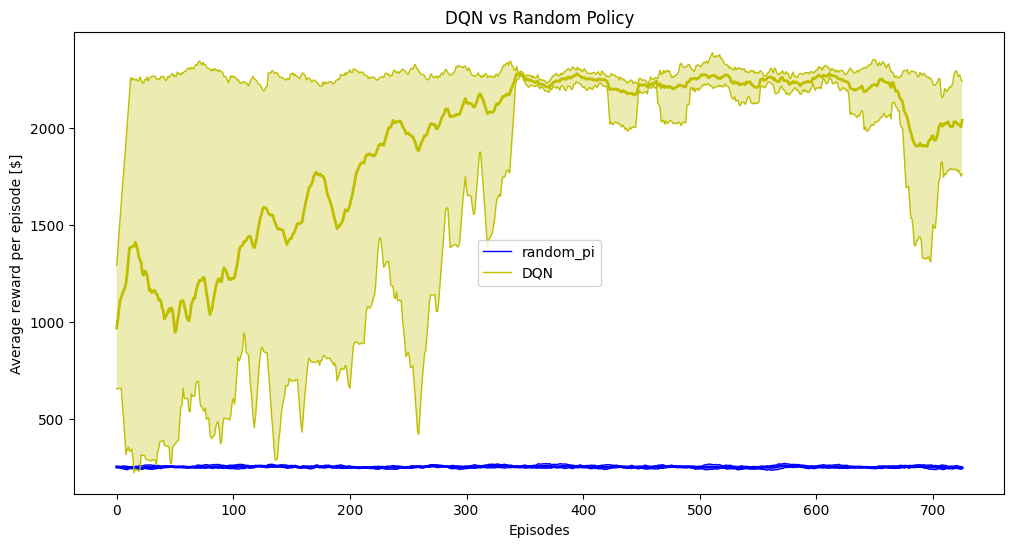

In [26]:
#define the plots
plt.figure(figsize=(12,6))
plt.title('DQN vs Random Policy')
plt.ylabel('Average reward per episode [$]')
plt.xlabel('Episodes')

#get the results of the 2 experiments
dqn_episodes = range(len(dqn_results['max_score']))
random_pi_episodes = range(len(random_pi_results['max_score']))

plt.plot(random_pi_results['max_score'], 'b', linewidth=1, label="random_pi")
plt.plot(random_pi_results['min_score'], 'b', linewidth=1)
plt.plot(random_pi_results['mean_score'], 'b', linewidth=2)
plt.fill_between(random_pi_episodes, random_pi_results['min_score'], random_pi_results['max_score'], facecolor='b', alpha=0.3)

plt.plot(dqn_results['max_score'], 'y', linewidth=1, label="DQN")
plt.plot(dqn_results['min_score'], 'y', linewidth=1)
plt.plot(dqn_results['mean_score'], 'y', linewidth=2)
plt.fill_between(dqn_episodes, dqn_results['min_score'], dqn_results['max_score'], facecolor='y', alpha=0.3)

plt.legend()
plt.show()

The plot above shows the comparison of the performances reached by DQN and the random policy, the average value obtained by the DQN policy is way higher than the one obtained by the random policy, meaning that our agent is actually learning something through the course of the episodes, even though the learning process is noisy at the beginning.\
The instability is mainly present at the begining as indicated by the high variance in the scores and the growing gap between the max and min scores.\
In particular once the DQN overcomes 300 episodes of interactions, the average reward obtained looks more stable with the two confidence bands closer to the mean value, this means that our agent has learned.

Of course in the training set cannot perform any better than 2500 of average reward, but we must assess the testing set generalization capabilities.

## 7. What our agent is capable of in reality <a name="capabilities--7"></a>

It is crucial to clarify a fundamental aspect of reinforcement learning applied to financial trading, we are somehow *in the middle of reinforcement learning and supervised learning problem*.\
While the problem is formally framed as a reinforcement learning task, it exhibits several characteristics that make it closer to an offline and supervised-like learning setting, as in between a problem of pattern recognition.

In particular, the actions taken by the agent do not influence the environment dynamics: the price time series is pre-generated and entirely exogenous. As a consequence, the environment is non-reactive, and the agent interacts with a fixed historical trajectory rather than a fully interactive Markov Decision Process. <small>[(see the Appendix on the Markovian assumptions)](#Appendix--9-A)</small>\
[See the fiancial market whale](https://fenefx.com/en/blog/what-is-a-financial-market-whale/)

This property introduces a significant risk of overfitting. Evaluating the cumulative reward obtained by the agent on the same time series used during training does not provide meaningful information about its true generalization capability. In such a setting, the agent may simply learn spurious correlations or regime-specific patterns present in the training data, achieving high in-sample performance without learning a robust trading strategy.

Therefore, performance evaluation must be conducted on strictly unseen time series, either from future time periods or from different assets, in order to assess the agent’s ability to generalize to a real and previously unobserved market environment. Only out-of-sample evaluation can provide a realistic estimate of the strategy’s effectiveness and risk profile.

Thus, we will evaluate the performance of our agent over a shifted and shorter environment, **over the same market**, this last thing it is fundamental again.\
We should test our policy on the same market over which it has been trained on, because different markets might have different types of characteristics, such as: market cap, amount of investors, regulatory rules, volatility...\
By same market, we also intend similarity in financial periods, such that training on **bullish** period must be tested on **bullish** period, and the same for a **bearish** market.

In [27]:
#instantiate a new environment, we will use it for testing the trained policy
#choose a shorter start_date - end_date range to speed up the evaluation phase
#HYP!
env = TradingEnv(ticker="QQQ", granularity="1d", sliding_window=10, start_date="2016-01-01", end_date="2017-01-01", initial_cash=10000, initial_share=10)

state_size = env.observation_space.shape
action_size = env.action_space.n

print('State Space: ', state_size)
print('Action Space: ', action_size)

State Space:  (10,)
Action Space:  3


It is important, to note that almost all financial time series show a drift, that even on short terms if strongly present, could induce a random policy to obtain successful cumulative reward.\
**In any case, the trained policy should always be higher than the random one, even if slightly higher, it means the agent at least has learnt something from the patterns of the training time series.**

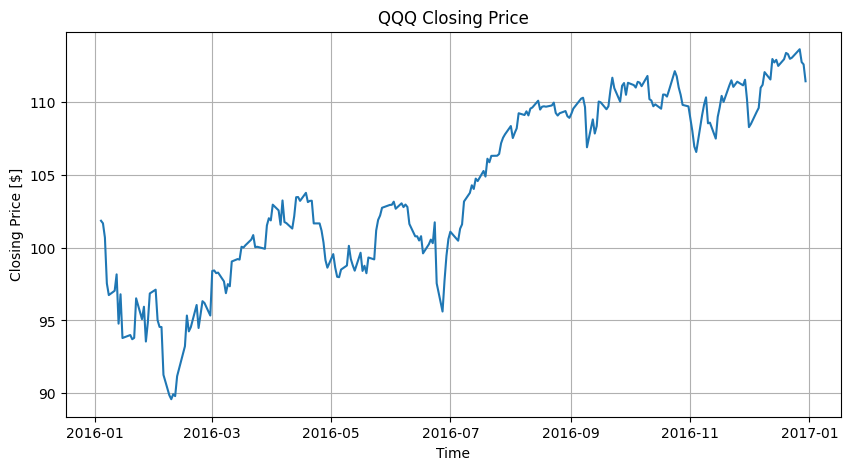

In [28]:
#method of the TradingEnv class to show the data used testing the trained policy
env.show_data()

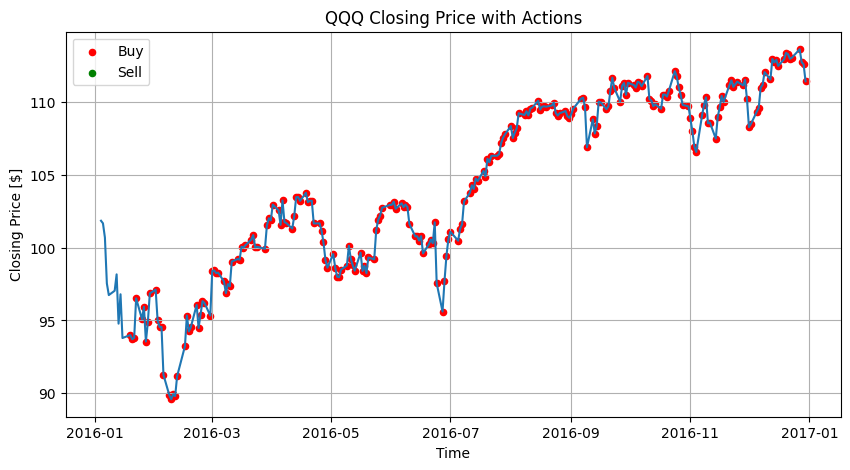

np.float64(1455.0520858764648)

In [29]:
#NOTE THAT IT WILL ANSWER ON THE BASIS OF THE LAST "online_q" TRAINED!
#we can even run it many times with many different input settings to draw a Design of Experiments curve
cumulative_reward, actions_taken = evaluate(dqn_pi, episodes=1)

env.show_data_with_actions(actions_taken) #the actions we took
cumulative_reward #the related return

In [30]:
#just for comparison test the perfomance of the random policy
env = TradingEnv(ticker="QQQ", granularity="1d", sliding_window=10, start_date="2016-01-01", end_date="2017-01-01", initial_cash=10000, initial_share=10)
evaluate(random_pi, episodes=1)[0]

np.float64(257.5812530517578)

As reported by the results above, our agent is able to **earn more than 5 times** the amount earned by the random policy.\
This is mainly due to the time series used for training, we have used the Invesco QQQ Trust, which is an index exchange-traded fund that tracks the performance of the Nasdaq-100. In general stock time series, specifically in the last 5 years, that are well known for being marked by the AI industry, hence companies working in related sectors are collecting all the related benefits, indeed Nasdaq's prices, as shown by the two plots, have a strong increasing drift, that hugely impacts their values and by definition the policy learned by the agent: **BUY**.

## 8. Conclusions, Limitations and Future Improvements <a name="Conclusions--8"></a>

The results highlight a difference between a **random policy** and the policy learned by the DQN agent.  
This suggests that the agent is able to capture **patterns** in market dynamics, potentially exploiting regularities that go beyond pure randomness. However, these results should be interpreted with caution, as financial markets are complex and highly noisy systems, and this is just an applicative-learning exercise.\
In our very simple vanilla implementation, the training time series is fundamental for the testing results, since a strongly bullish/bearish drift in the training time series will impact the testing behaviour in terms of buying/selling.

It is well known in the financial literature that markets may exhibit recurring structures <small>[(see again FFT in Finance)](https://github.com/fraro01/Fourier-Transform-in-Finance)</small>, such as [CandleStick patterns](https://en.wikipedia.org/wiki/Candlestick_pattern); which reflect collective trader behavior and market psychology. Reinforcement learning methods may implicitly learn such patterns without explicitly encoding them, like in pattern recognition.\
In this sense we have built an adaptive system capable of performing pattern recongition, that could be actually used for many other cases in many other environments!

### Limitations

Despite the results, the proposed model suffers from several limitations:

- **Strong assumptions on the action space**:  
  The agent can only buy, sell, or hold a single unit of the asset at each step. This is a restrictive assumption that does not reflect real trading behavior.

- **Simplified state representation**:  
  The observation space is limited to a fixed-size sliding window of past price variations, excluding other potentially informative features such as volume, volatility indicators, or macroeconomic signals.\
  All these further metrics are the ones that strongly make a difference between our simple vanilla-base implementation and the scientific papers cited in the SOTA section.

- **Sensitivity to hyperparameters**:  
  The performance of the model strongly depends on the choice of neural network architecture and DQN hyperparameters, which have not been exhaustively optimized.\
  Furthermore even the environment is strongly dependent on hyperparamters, that should be properly defined by a deep financial knowledge.\
  Even the initialization of the cash and share hyperparameters is crucial, because from this, the agent could learn degenerative behaviours.

- **Limited time horizon and computational constraints**:  
  Computational power limits the amount of historical data and the length of training, potentially preventing the agent from learning properly and from having stronger generalization capabilities.\
  Due to this, the testing time series, must be similar in terms of financial market to the training time series, otherwise we risk to train and test on two different environments.

### Future Improvements

Several directions can be explored to improve the model (many of them can be achieved by manipulating the script `tradingenv.py`):

- **Richer action space**:  
  Allow the agent to buy or sell multiple units per action, enabling position sizing and more realistic portfolio management.\
  For the sake of reality, we should even introduce, transaction fees.

- **Expanded state space**:  
  Incorporate additional features such as technical indicators, trading volume, volatility measures, or external signals.\
  **This is fundamental, since it is the features that really can make a real change in terms of strong improvements, as demonstrated by the cited scientific papers in the SOTA section.**

- **Hyperparameters optimization**:  
  Perform a systematic search (e.g. grid search or random search) over network architectures and learning parameters.\
  Especially for time resolution, to extend the framework to different time scales, such as intraday or hourly trading, to analyze high-frequency dynamics.

- **Use of finer models**:  
  We could try to use different models, such as DDQN, Rainbow or even policy-based methods.\
  Even on the Neural Network Architecture we could implement methods more suited for time series, such as Recurrent Neural Networks, e.g.: GRU, LSTM or the WaveNet.\
  Even for the sampling of the experience replay buffer we could implement finer models, such as: Prioritized Experience Replay, stratified/temporal-aware, but always keeping in mind that we need to preserve the context in our samples!

  A very interesting path to follow would be the construction of a "filtering pipeline", with the application of a Fast Fourier Transform at the beginning [FFT in Finance](https://github.com/fraro01/Fourier-Transform-in-Finance) that filters the unwanted noise of the price variations (set the percentage threshold), and then the application of the DQN RL algorithm once the prices are "cleaned".

- **Real-world deployment**:  
  After proper validation and risk management, the trained agent could be connected to a trading bot interfaced with a real trading wallet.


Overall, further experimentation and validation are required before considering real-world applications.

## 9. Appendix <a name="Appendix--9"></a>

### 9.A. On the Markov Decision Process formulation in financial trading <a name="Apendix--9-A"></a>

A Markov Decision Process (MDP) is defined by a tuple $(\mathcal{S}, \mathcal{A}, P, R, \gamma)$, where the transition function $P(s_{t+1} \mid s_t, a_t)$ explicitly depends on the action taken by the agent.\
This dependency implies that actions actively shape the future evolution of the environment.

In the context of financial trading on historical price data, this assumption does not strictly hold.\
The price time series is pre-generated and **entirely exogenous**, meaning that *the agent’s actions do not influence the future market states.*
As a consequence, the state transition dynamics satisfy:

$P(s_{t+1} \mid s_t, a_t) = P(s_{t+1} \mid s_t)$

The agent’s actions affect only the reward function, through realized profits and losses, while the environment evolution remains unchanged.\
This results in a non-reactive environment, where the agent interacts with a fixed historical trajectory rather than a fully interactive MDP.

Therefore, the trading problem is more accurately described as an offline reinforcement learning problem with exogenous dynamics, or as a degenerate MDP.\
This formulation highlights the increased risk of overfitting and the necessity of strict out-of-sample evaluation, as the agent may otherwise exploit idiosyncratic patterns specific to the training data rather than learning a robust trading policy.
